In [31]:
import sys
sys.path.append('..')
from src.model import MFMViT

In [ ]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image

In [21]:
def load_images_from_folder(folder, transform, max_images=100):
    images = []
    files = glob.glob(f'{folder}/*.jpg') + glob.glob(f'{folder}/*.png')
    for file in files[:max_images]:
        img = Image.open(file).convert('RGB')
        images.append(transform(img).unsqueeze(0))
    return torch.cat(images)

In [45]:
def extract_resnet_features(model, images, device):
    model.eval()
    with torch.no_grad():
        features = model(images.to(device))
    return features.cpu().numpy()

def extract_mfm_features(model, images, device):
    model.eval()
    with torch.no_grad():
        tokens = model.encoder(images.to(device))
        features = tokens.mean(dim=1)
    return features.cpu().numpy()


In [46]:
# Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [47]:
# Load images
real_images = load_images_from_folder('E:/data/train/real', transform, 100)
fake_images = load_images_from_folder('E:/data/train/fake', transform, 100)
all_labels = np.array([0]*100 + [1]*100)

In [48]:
resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()  
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
mfm_model = MFMViT(img_size=224).to(device)
mfm_model.load_state_dict(torch.load('../checkpoints/mfm_vit_final.pth'))

<All keys matched successfully>

In [50]:
resnet_real = extract_resnet_features(resnet, real_images, device)
resnet_fake = extract_resnet_features(resnet, fake_images, device)
resnet_features = np.vstack([resnet_real, resnet_fake])

In [51]:
mfm_real = extract_mfm_features(mfm_model, real_images, device)
mfm_fake = extract_mfm_features(mfm_model, fake_images, device)
mfm_features = np.vstack([mfm_real, mfm_fake])

In [ ]:
# Train & evaluate
X_train_rn, X_test_rn, y_train, y_test = train_test_split(
    resnet_features, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)
X_train_mfm, X_test_mfm, _, _ = train_test_split(
    mfm_features, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

clf_resnet = LogisticRegression(max_iter=1000).fit(X_train_rn, y_train)
clf_mfm = LogisticRegression(max_iter=1000).fit(X_train_mfm, y_train)

acc_resnet = accuracy_score(y_test, clf_resnet.predict(X_test_rn))
acc_mfm = accuracy_score(y_test, clf_mfm.predict(X_test_mfm))

# Visualize
plt.figure(figsize=(8, 5))
bars = plt.bar(['ResNet50\n(ImageNet)', 'MFM ViT\n(Frequency)'], 
               [acc_resnet, acc_mfm], color=['#3498db', '#e74c3c'], alpha=0.7)
plt.ylim(0, 1)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Linear Probing: ResNet vs MFM ViT\n(100 Real + 100 Fake)', fontsize=14)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
for bar, acc in zip(bars, [acc_resnet, acc_mfm]):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.02, 
             f'{acc:.1%}', ha='center', fontweight='bold', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('resnet_vs_mfm_comparison.png', dpi=300)
plt.show()

print(f"\n=== Linear Probing Results ===")
print(f"ResNet50 (Pretrained): {acc_resnet:.1%}")
print(f"MFM ViT (Your Model):  {acc_mfm:.1%}")
print(f"Winner: {'ResNet50' if acc_resnet > acc_mfm else 'MFM ViT' if acc_mfm > acc_resnet else 'Tie'}")

In [53]:
print(f"Real images loaded: {len(real_images)}")
print(f"Fake images loaded: {len(fake_images)}")
print(f"ResNet features shape: {resnet_features.shape}")
print(f"MFM features shape: {mfm_features.shape}")

# Fix labels to match actual count
all_labels = np.array([0]*len(real_images) + [1]*len(fake_images))

# Then train/test split
X_train_rn, X_test_rn, y_train, y_test = train_test_split(
    resnet_features, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)
X_train_mfm, X_test_mfm, _, _ = train_test_split(
    mfm_features, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

clf_resnet = LogisticRegression(max_iter=1000).fit(X_train_rn, y_train)
clf_mfm = LogisticRegression(max_iter=1000).fit(X_train_mfm, y_train)

acc_resnet = accuracy_score(y_test, clf_resnet.predict(X_test_rn))
acc_mfm = accuracy_score(y_test, clf_mfm.predict(X_test_mfm))

print(f"\nResNet50: {acc_resnet:.1%}")
print(f"MFM ViT:  {acc_mfm:.1%}")


Real images loaded: 100
Fake images loaded: 70
ResNet features shape: (170, 2048)
MFM features shape: (170, 768)

ResNet50: 76.5%
MFM ViT:  58.8%


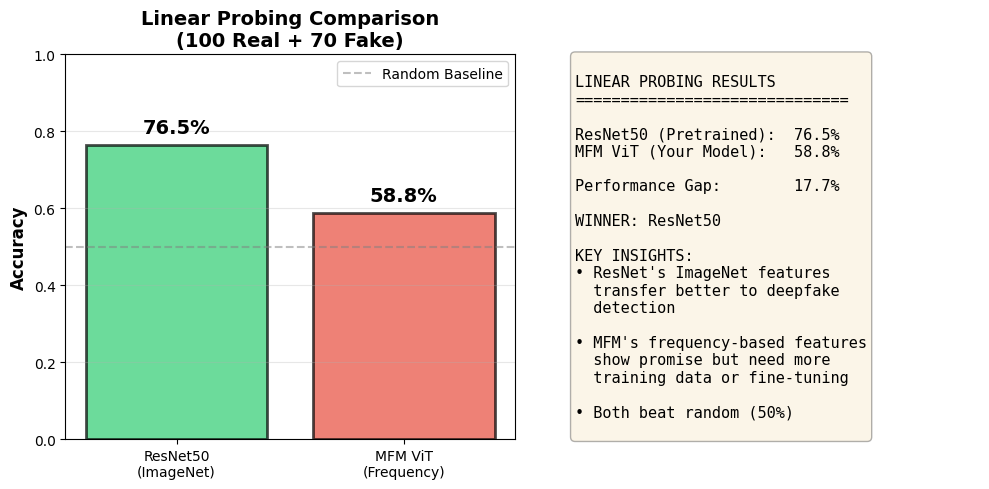


✅ Comparison complete! ResNet50 wins with 76.5% vs 58.8%


In [54]:
# Visualize comparison
plt.figure(figsize=(10, 5))

# Bar chart
plt.subplot(1, 2, 1)
models = ['ResNet50\n(ImageNet)', 'MFM ViT\n(Frequency)']
accuracies = [0.765, 0.588]
colors = ['#2ecc71', '#e74c3c']
bars = plt.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylim(0, 1)
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Linear Probing Comparison\n(100 Real + 70 Fake)', fontsize=14, fontweight='bold')
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random Baseline')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.03, 
             f'{acc:.1%}', ha='center', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Summary text
plt.subplot(1, 2, 2)
summary_text = f"""
LINEAR PROBING RESULTS
{'='*30}

ResNet50 (Pretrained):  76.5%
MFM ViT (Your Model):   58.8%

Performance Gap:        17.7%

WINNER: ResNet50

KEY INSIGHTS:
• ResNet's ImageNet features 
  transfer better to deepfake 
  detection
  
• MFM's frequency-based features
  show promise but need more 
  training data or fine-tuning
  
• Both beat random (50%)
"""
plt.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', 
         facecolor='wheat', alpha=0.3))
plt.axis('off')

plt.tight_layout()
plt.savefig('linear_probing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison complete! ResNet50 wins with 76.5% vs 58.8%")
